# Lesson 13. SimPy &mdash; balking and reneging

### SA421 Fall 2015

## Setup

* Nothing new here today!

In [1]:
##### Setup #####
# Import RandomState and rand from NumPy
from numpy.random import RandomState, rand

# Import everything from SimPy
from SimPy.Simulation import *

# Import plot function from Matplotlib
from matplotlib.pyplot import plot

# Run Matplotlib magic to show plots directly in the notebook
%matplotlib inline

# Make Matplotlib plots display as SVG files, which are cleaner
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Deterministic balking

**Problem.** Customers visit the neighborhood hair stylist Fantastic Dan for haircuts. The customer interarrival time is exponentially distributed with mean 20 minutes. Each haircut takes Fantastic Dan anywhere from 15 to 25 minutes, uniformly distributed. This time also includes the initial greetings and the transaction of money at the end of the haircut.

<span style="color:#a00000">Suppose Fantastic Dan's shop only has 3 seats for waiting customers. Any customers who arrive when the shop is full simply leave: that is, they **balk**.</span>

<span style="color:#a00000">How many customers balked? What fraction of customers balked? Assume an 8 hour day.</span>

* **Balking** occurs when potential customers arriving at a queueing system choose not to enter it.


* Below is SimPy code for the original Fantastic Dan problem:
    - The built-in monitors for `R.server` have been set up.
    - Interarrival times and service times are generated from separate streams.
    - No performance measures are computed.

In [2]:
##### Parameters #####
class P:
    # Customers arrive at the entrance with exponentially distributed
    # interarrival times with mean 20
    interarrivalTimeMean = 20
    
    # Service times are uniformly distributed between 15 and 25 minutes
    serviceTimeMin = 15
    serviceTimeMax = 25
    
    # One server: Fantastic Dan works by himself
    nServers = 1
    
    # Shop is open for 8 continuous hours
    simulationTimeMax = 8 * 60
    
    
##### Streams #####
class S:
    inter = RandomState()
    serve = RandomState()
    
    
##### Processes #####
# Customer
class Customer(Process):
    def behavior(self):
        # Customer arrives, joins queue
        yield request, self, R.server  
        
        # Customer is released from queue and starts service
        serviceTime = S.serve.uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
        yield hold, self, serviceTime
        
        # Customer finishes service, leaves
        yield release, self, R.server

# Entrance
class Entrance(Process):
    def behavior(self):
        # At the start of the simulation, no customers have arrived
        nCustomers = 0
        
        # Customer arrivals
        while True:
            # Wait until the next arrival
            interarrivalTime = S.inter.exponential(scale = P.interarrivalTimeMean)
            yield hold, self, interarrivalTime
            
            # Create a new customer using the template defined in the Customer class
            c = Customer(name = "Customer {0}".format(nCustomers))
            
            # Activate the customer's behavior
            activate(c, c.behavior())

            # Count this new customer
            nCustomers += 1

            
##### Resources #####
class R:
    # Server
    server = None


##### Model #####
def model(interSeed, serveSeed):
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the interarrival time random number stream
    S.inter.seed(interSeed)
    
    # Initialize a seed for the service time random number stream
    S.serve.seed(serveSeed)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* To modify customer behavior so that it includes the possibility of balking, we need to do several things.


* First, let's create a new parameter for the queue capacity. 

In [3]:
P.queueCapacity = 3

* Since we are interested in the number and fraction of balking customers, we need to set up a monitor to keep track of the number of customers who balk.

In [4]:
##### Monitors #####
class M:
    balk = None
    

##### Redefine model() to include monitors #####
def model(interSeed, serveSeed):
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the interarrival time random number stream
    S.inter.seed(interSeed)
    
    # Initialize a seed for the service time random number stream
    S.serve.seed(serveSeed)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)
    
    # Create the monitor for balking
    M.balk = Monitor()

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* Now we're ready to change the SimPy code that defines the customer's behavior so that it includes balking.


* SimPy automatically maintains two lists for each resource:
    - `R.server.waitQ`, the list of customers in the queue waiting for `R.server` at any given time.
    - `R.server.activeQ` is a list of customers being served by `R.server` at any given time.


* So, before the customer joins the queue, we can insert an `if` statement that checks whether there is room in the queue:
    * If there is room in the queue, we have the balking monitor observe a value of "0", and we have the customer join the queue and get served, just like before. 
    * If the queue is full, we have the balking monitor observe a value of "1", and have the customer do nothing to represent him or her not entering the queue.


* Let's also add some `print` statements so that we can make sure the simulation is behaving as we expect.

In [5]:
class Customer(Process):
    def behavior(self):
        print("Time {0}: {1} arrives, queue length is {2}".format(now(), self.name, len(R.server.waitQ)))
        if len(R.server.waitQ) < P.queueCapacity:
            # Customer arrives, doesn't balk
            M.balk.observe(0)
            
            # Customer joins queue
            yield request, self, R.server
            
            # Customer released from queue, starts haircut
            serviceTime = S.serve.uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
            yield hold, self, serviceTime
            
            # Customer finishes haircut, leaves
            yield release, self, R.server
        else:
            # Customer arrives, balks
            print("Time {0}: {1} balks".format(now(), self.name))
            M.balk.observe(1)

* Now, let's run the simulation once.

In [6]:
model(interSeed = 123, serveSeed = 123)

Time 23.84544286962211: Customer 0 arrives, queue length is 0
Time 30.58679252313273: Customer 1 arrives, queue length is 0
Time 35.73247412547374: Customer 2 arrives, queue length is 1
Time 51.76114776176749: Customer 3 arrives, queue length is 1
Time 77.18256647151634: Customer 4 arrives, queue length is 1
Time 88.18451718709588: Customer 5 arrives, queue length is 1
Time 167.20415856339025: Customer 6 arrives, queue length is 0
Time 190.29700403842475: Customer 7 arrives, queue length is 0
Time 203.41140790664213: Customer 8 arrives, queue length is 0
Time 213.36688195067714: Customer 9 arrives, queue length is 1
Time 221.7737269558251: Customer 10 arrives, queue length is 1
Time 247.89012489597826: Customer 11 arrives, queue length is 1
Time 259.43556843203885: Customer 12 arrives, queue length is 1
Time 260.6662244166868: Customer 13 arrives, queue length is 2
Time 270.81765142095713: Customer 14 arrives, queue length is 3
Time 270.81765142095713: Customer 14 balks
Time 297.605516

* What does the `M.balk` monitor look like?

In [7]:
print("M.balk = {0}".format(M.balk))

M.balk = [[23.84544286962211, 0], [30.58679252313273, 0], [35.73247412547374, 0], [51.76114776176749, 0], [77.18256647151634, 0], [88.18451718709588, 0], [167.20415856339025, 0], [190.29700403842475, 0], [203.41140790664213, 0], [213.36688195067714, 0], [221.7737269558251, 0], [247.89012489597826, 0], [259.43556843203885, 0], [260.6662244166868, 0], [270.81765142095713, 1], [297.6055162209746, 0], [301.6354014331482, 0], [305.49379394984777, 1], [320.66037073642343, 0], [335.8387436818089, 0], [355.9631049070825, 0], [393.8298869462596, 0], [419.6099970126643, 0], [438.49472453166504, 0], [464.1293313283111, 0], [471.929797715583, 0]]


* Using the built-in methods for a monitor, we can compute the number of customers who balked, and the fraction of customers who balked.

In [8]:
print("Number of customers who balked = {0}".format(M.balk.total()))
print("Fraction of customers who balked = {0}".format(M.balk.mean()))

Number of customers who balked = 2.0
Fraction of customers who balked = 0.07692307692307693


* With this simulation in hand, you could then perform many replications and compute both point and interval estimates of the mean fraction of customers who balked.

## Probabilistic balking

* Now let's go back to assuming that Fantastic Dan's shop does not have a queue capacity.


* Suppose instead that a customer balks **probabilistically:** in particular, the probability that a customer balks grows as the length of the queue grows.
    
    
* For instance, suppose that if $x$ is the current number of customers in the queue, the probability that a customer balks is $\frac{x}{x+1}$.


* Let's plot this balking probabillity as a function of the number of customers in the queue, just to get an idea of what's going on.

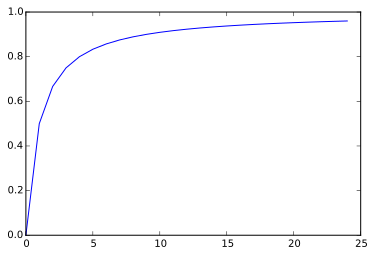

In [9]:
x = range(25)
y = [x[i] / (x[i] + 1) for i in range(25)]
plot(x, y)

* How can we make sure that customers balk according to this probability?

**Example.** Modify the `Customer` process so that customers balk with probability $\frac{x}{x+1}$, where $x$ is the current number of customers in the queue. Run the simulation once and compute the number of customers who balked, and the fraction of customers who balked.


*Hint.* How can you use a Uniform[0,1] random variable (i.e., a random number generated by `rand()`) to make sure something happens 90% of the time? 30% of the time? $\frac{x}{x+1}$ of the time?

In [10]:
class Customer(Process):
    def behavior(self):
        x = len(R.server.waitQ)
        if rand() >= x / (x + 1):
            # Customer arrives, doesn't balk
            M.balk.observe(0)
            
            # Customer joins queue
            yield request, self, R.server
            
            # Customer released from queue, starts haircut
            serviceTime = S.serve.uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
            yield hold, self, serviceTime
            
            # Customer finishes haircut, leaves
            yield release, self, R.server
        else:
            # Customer arrives, balks
            M.balk.observe(1)

In [11]:
# Run model
model(interSeed = 123, serveSeed = 123)

# Performance measures
print("Number of customers who balked = {0}".format(M.balk.total()))
print("Fraction of customers who balked = {0}".format(M.balk.mean()))

Number of customers who balked = 6.0
Fraction of customers who balked = 0.23076923076923078


## Reneging

* Let's now focus on **reneging**.


* **Reneging** occurs when customers in a queueing system choose to leave the system prior to receiving service.


* Suppose that customers will wait at most 30 minutes in the queue. If they're not served by then, they simply leave the shop.


* Let's compute the number and fraction of reneging customers.


* To modify customer behavior so that it includes the possibility of balking, we need to do several things.


* First, let's create a new parameter for the maximum time a customer is willing to wait before he/she reneges.

In [12]:
P.renegeTime = 30

* Let's also create a new monitor that records whether a customer reneges or not.

In [13]:
# Add monitor to class M, already defined above
M.renege = None

##### Redefine model() to include monitors #####
def model(interSeed, serveSeed):
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the interarrival time random number stream
    S.inter.seed(interSeed)
    
    # Initialize a seed for the service time random number stream
    S.inter.seed(interSeed)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)
    
    # Create monitor for balking
    M.balk = Monitor()
    
    # Create monitor for reneging
    M.renege = Monitor()

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* Now we're ready to change the SimPy code that defines the customer's behavior so that it includes reneging.


* We model reneging through the `yield` statement: when the customer joins the queue, the customer waits for the server to be free, or the maximum wait time to elapse.


* So instead of
```
yield request, self, R.server
```
like we would ordinarily have, we write
```
yield (request, self, R.server), (hold, self, P.renegeTime)
```

* We can detect whether a customer acquires service through the function `self.acquired(R.server)`:
    - If `self.acquired(R.server) == True`, then the customer is served.
    - If `self.acquired(R.server) == False`, the customer reneges.


* Let's also print the time the customer spends in the queue to make sure the simulation behaves as we expect.

In [14]:
class Customer(Process):
    def behavior(self):
        # Record time customer arrives
        arrivalTime = now()
        
        # Customer arrives, joins queue and waits for server to become available, or leaves
        yield (request, self, R.server), (hold, self, P.renegeTime)
        
        # Record time customer leaves queue
        leaveQTime = now()
        print("Time {0}: {1} leaves queue after waiting {2} minutes".format(now(), self.name, leaveQTime - arrivalTime))
        
        # Customer is released from queue and starts service OR ...
        if self.acquired(R.server):
            # Customer doesn't renege
            print("Time {0}: {1} starts service".format(now(), self.name))
            M.renege.observe(0) 
            serviceTime = S.serve.uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
            yield hold, self, serviceTime
        
            # Customer finishes service, leaves
            yield release, self, R.server
        
        # ... customer reneges
        else:
            # Customer reneges
            print("Time {0}: {1} reneges".format(now(), self.name))
            M.renege.observe(1)

* Now let's run the simulation once.

In [15]:
model(interSeed = 123, serveSeed = 123)

Time 23.84544286962211: Customer 0 leaves queue after waiting 0.0 minutes
Time 23.84544286962211: Customer 0 starts service
Time 44.163718740590774: Customer 1 leaves queue after waiting 13.576926217458045 minutes
Time 44.163718740590774: Customer 1 starts service
Time 65.50772832610399: Customer 2 leaves queue after waiting 29.775254200630243 minutes
Time 65.50772832610399: Customer 2 starts service
Time 81.76114776176749: Customer 3 leaves queue after waiting 30.0 minutes
Time 81.76114776176749: Customer 3 reneges
Time 89.00204626688188: Customer 4 leaves queue after waiting 11.819479795365538 minutes
Time 89.00204626688188: Customer 4 starts service
Time 111.24659951548823: Customer 5 leaves queue after waiting 23.06208232839235 minutes
Time 111.24659951548823: Customer 5 starts service
Time 167.20415856339025: Customer 6 leaves queue after waiting 0.0 minutes
Time 167.20415856339025: Customer 6 starts service
Time 190.29700403842475: Customer 7 leaves queue after waiting 0.0 minute

* Finally, let's compute the number and fraction of customers that reneged.

In [16]:
print("Number of customers who reneged = {0}".format(M.renege.total()))
print("Fraction of customers who reneged = {0}".format(M.renege.mean()))

Number of customers who reneged = 4.0
Fraction of customers who reneged = 0.16


## If we have time... with a neighbor

**Problem.** Fantastic Dan has decided to add two more seats in the waiting area of his shop, raising the total number of seats in the waiting area to 5. Any customers who arrive when the shop is full still leave without receiving service. In addition, with your help, Fantastic Dan has determined that the customer reneging time is not deterministic; instead, it can be modeled as an exponential random variable with mean 22 minutes.

Modify the SimPy code below to reflect these changes in Fantastic Dan's shop. Assume an 8 hour day. Run your simulation once. What fraction of customers balked? What fraction of customers reneged? Compare your numbers to the ones we obtained above in the earlier simulations. Do they make sense?

In [17]:
##### Parameters #####
class P:
    # Customers arrive at the entrance with exponentially distributed
    # interarrival times with mean 20
    interarrivalTimeMean = 20
    
    # Service times are uniformly distributed between 15 and 25 minutes
    serviceTimeMin = 15
    serviceTimeMax = 25
    
    # Renege times are exponentially distributed with mean 22 minutes
    renegeTimeMean = 22
    
    # One server: Fantastic Dan works by himself
    nServers = 1
    
    # Number of seats in waiting area of shop
    queueCapacity = 5
    
    # Shop is open for 8 continuous hours
    simulationTimeMax = 8 * 60
    
    
##### Streams #####
class S:
    inter = RandomState()
    serve = RandomState()
    renege = RandomState()
    
    
##### Processes #####
# Customer
class Customer(Process):
    def behavior(self):
        # If there is an open seat in the waiting area, 
        # the customer enters the shop
        if len(R.server.waitQ) < P.queueCapacity:
            # Customer did not balk
            M.balk.observe(0)
            
            # Customer arrives, joins queue and waits for server
            # to become available, or leaves (reneges)
            renegeTime = S.renege.exponential(scale = P.renegeTimeMean) 
            yield (request, self, R.server), (hold, self, renegeTime) 

            # Customer is released from queue and starts service OR ...
            if self.acquired(R.server):
                # Customer does not renege
                M.renege.observe(0)
                
                # Customer is released from queue and starts service
                serviceTime = S.serve.uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
                yield hold, self, serviceTime

                # Customer finishes service, leaves
                yield release, self, R.server
            else:
                # Customer reneged
                M.renege.observe(1)
        # Otherwise, the customer leaves the shop
        else:
            # Customer did balk
            M.balk.observe(1)        

# Entrance
class Entrance(Process):
    def behavior(self):
        # At the start of the simulation, no customers have arrived
        nCustomers = 0
        
        # Customer arrivals
        while True:
            # Wait until the next arrival
            interarrivalTime = S.inter.exponential(scale = P.interarrivalTimeMean)
            yield hold, self, interarrivalTime
            
            # Create a new customer using the template defined in the Customer class
            c = Customer(name = "Customer {0}".format(nCustomers))
            
            # Activate the customer's behavior
            activate(c, c.behavior())

            # Count this new customer
            nCustomers += 1

            
##### Resources #####
class R:
    # Server
    server = None
    
    
##### Monitors #####
class M:
    balk = None
    renege = None


##### Model #####
def model(interSeed, serveSeed, renegeSeed):
    # Initialize SimPy 
    initialize()

    # Initialize seeds for the interarrival, service, 
    # and renege time random number streams
    S.inter.seed(interSeed)
    S.serve.seed(serveSeed)
    S.renege.seed(renegeSeed)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)
    
    # Create monitors for balking and reneging
    M.balk = Monitor()
    M.renege = Monitor()

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

In [18]:
##### Experiment #####
# Run the model once
model(123, 123, 123)

In [19]:
# Compute fraction of customers who balked
M.balk.mean()

0.0

In [20]:
# Compute fraction of customers who reneged
M.renege.mean()

0.32